### Libraries ###

In [127]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from scipy.stats import pearsonr, zscore, f_oneway
from matplotlib.colors import LinearSegmentedColormap
from factor_analyzer.factor_analyzer import calculate_kmo, FactorAnalyzer #
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import plot_tree, DecisionTreeClassifier
from sklearn.cluster import KMeans
from sklearn.linear_model import LogisticRegression #
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, r2_score, accuracy_score, classification_report, f1_score, silhouette_score
from sklearn.model_selection import train_test_split

### Import initial dataset ###

In [ ]:
path = r'C:\Users\chung\Downloads\Uptrail\Week 4\raw_dataset_week_4.xlsx'
data = pd.read_excel(path)

data['Date'] = pd.to_datetime(data['Date'])

#print(data.head)
#print(data.describe())

## 0 - Data Transformation: ##
- Null value detection & handling.
- Duplicate detection & handling.
- Handling outliers.

Create a clean dataset.

In [263]:
clean_data = data.copy()

clean_data['Date'] = pd.to_datetime(clean_data['Date'])

Null value detection.

In [262]:
#Detect columns with null values.
empty_columns = data.columns[data.isnull().any()].tolist()
print(empty_columns)

['Date', 'Income', 'Credit_Score', 'Loan_Amount']


Empty fields & Methodology:
- Date - Use median.
- Income - Use mean for normal distribution, otherwise median.
- Credit Score - Use median.
- Loan Amount - Use median.

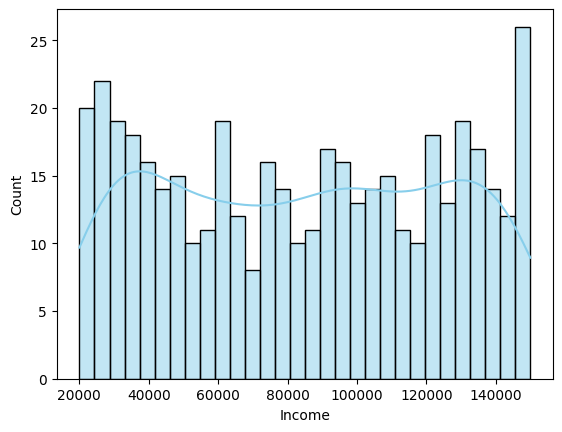

In [239]:
sns.histplot(data['Income'], kde=True, bins=30, color='skyblue')
plt.show()

Update empty values.

In [235]:
print(f'Median Date: {data["Date"].median()}')
clean_data['Date'] = clean_data['Date'].fillna(data['Date'].median())

print(f'Median Income: {data["Income"].median()}')
clean_data['Income'] = clean_data['Income'].fillna(data['Date'].median())

print(f'Median Credit_Score: {data["Credit_Score"].median()}')
clean_data['Credit_Score'] = clean_data['Credit_Score'].fillna(data['Date'].median())

print(f'Median Loan_Amount: {data["Loan_Amount"].median()}')
clean_data['Loan_Amount'] = clean_data['Loan_Amount'].fillna(data['Date'].median())

Median Date: 2024-02-29 00:00:00
Median Income: 85375.5
Median Credit_Score: 588.5
Median Loan_Amount: 29817.0


Identify dupes.

In [236]:
#Duplicate rows.
dupes = clean_data[clean_data.duplicated()]
print(f'Number of duplicates: {dupes.shape[0]}')

#Excluding IDs
exclude_ID = clean_data.columns.difference(['Customer_ID'])
dupes_noID = clean_data[clean_data.duplicated(subset=exclude_ID)]
print(f'Number of duplicates excluding Customer ID: {dupes_noID.shape[0]}')

Number of duplicates: 0
Number of duplicates excluding Customer ID: 0


Outlier detection using z-scores.

<b> Note: If a type error for data_z appears, run 'Create a Clean Dataset' again. </b>

In [265]:
#Number of standard deviations from normal distribution. Default is 3.
outlier_std = 3

quantitative_fields = ['Age', 'Income', 'Spending_Score', 'Credit_Score', 'Loan_Amount', 'Previous_Defaults', 'Marketing_Spend', 'Purchase_Frequency', 'Sales']

data_z = pd.DataFrame(zscore(clean_data[quantitative_fields], nan_policy='omit'), columns=quantitative_fields, index=clean_data.index)

outlier_mask = (abs(data_z) > outlier_std).any(axis=1)
outliers = clean_data[outlier_mask]

print(f'Outliers in data: {outliers.shape[0]}')

Outliers in data: 0


### Statistical Analysis ###

Correlation Matrix

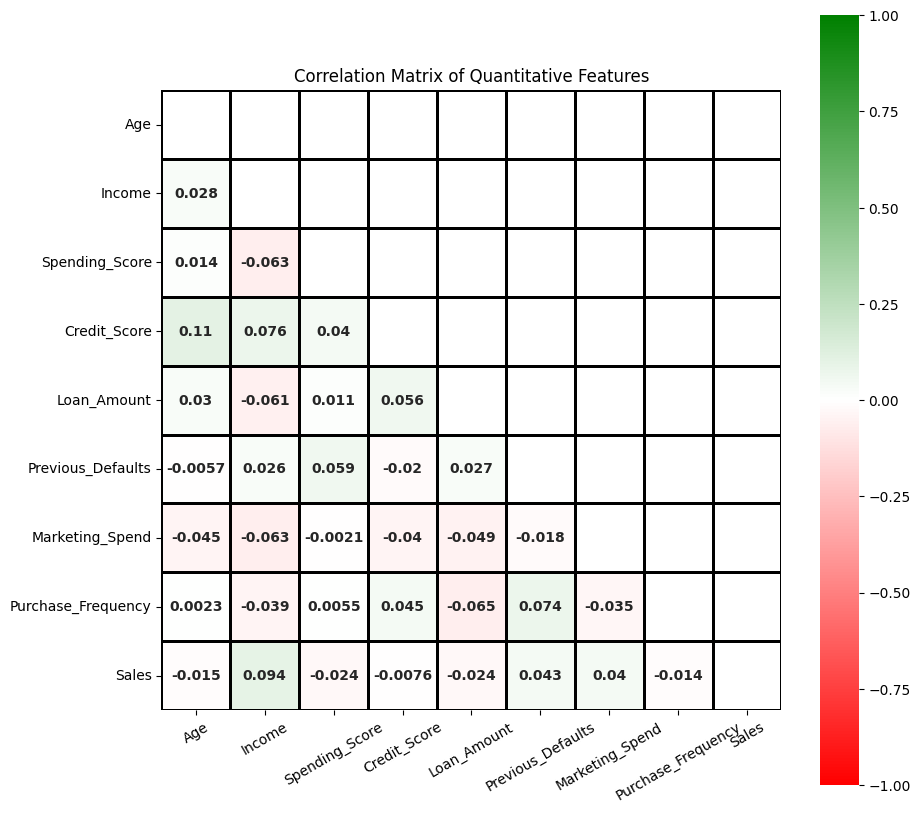

In [266]:
corr_data = clean_data[quantitative_fields].corr()
#print(corr_data)

gradient = LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256) 
p_values_corr = round(corr_data.corr(method=lambda x, y: pearsonr(x, y)[1]), 4)
#print(p_values_corr)

#Where p-values below (default) 0.05 are statistical significant.
stat_sig = 0.05

#Masks
mask = np.triu(corr_data)
p_mask = np.invert(np.tril(p_values_corr < stat_sig))

x, fig = plt.subplots(figsize=(10,10))

sns.heatmap(corr_data, mask=mask, cmap=gradient, vmin=-1, vmax=1, linewidths=2, linecolor='black', annot=True, annot_kws={'fontweight' : 'bold'}, square=True)
plt.title('Correlation Matrix of Quantitative Features')
plt.xticks(rotation=30)
plt.show()

Churn Rate

In [26]:
total_records = len(clean_data)
churned_count = clean_data.loc[clean_data['Customer_Churn'] == 0, 'Customer_Churn'].count()

print(f'Churn Rate (%): {(churned_count/total_records) * 100}')

Churn Rate (%): 74.6


### Import Transformed Dataset ###

In [ ]:
path = r'C:\Users\chung\Downloads\Uptrail\Week 4\Submission\transformed_dataset_week_4.xlsx'
data = pd.read_excel(path)

data['Date'] = pd.to_datetime(data['Date'])

Correlation Matrix Part 2

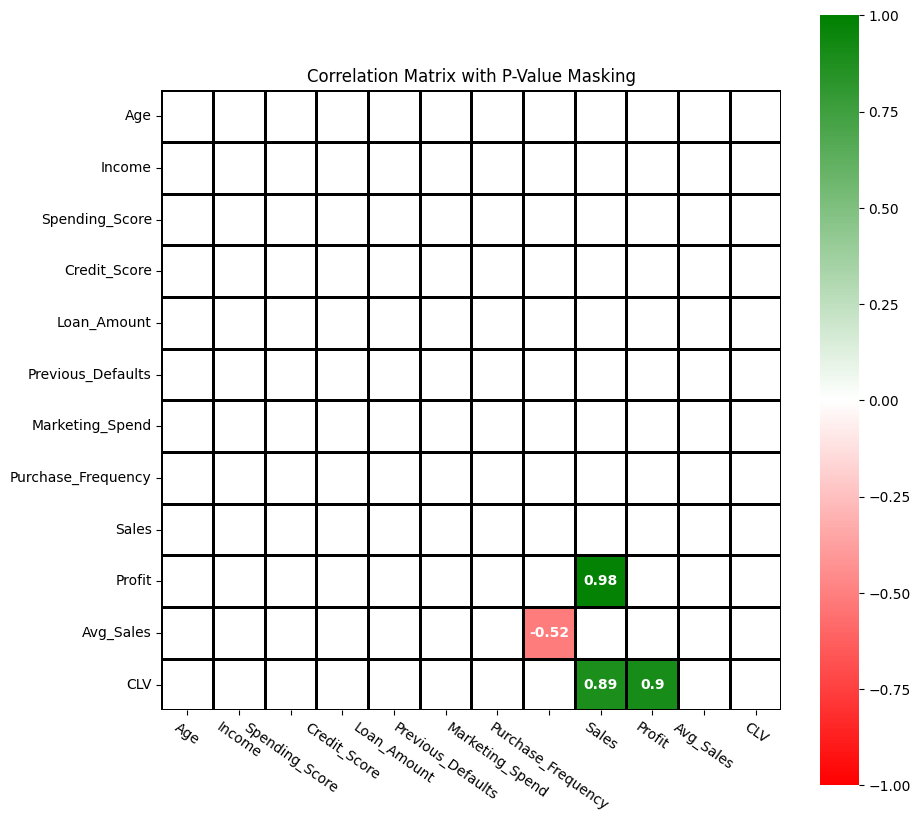

In [269]:
quantitative_fields = ['Age', 'Income', 'Spending_Score', 'Credit_Score', 'Loan_Amount', 'Previous_Defaults', 'Marketing_Spend', 'Purchase_Frequency', 'Sales', 'Profit', 'Avg_Sales', 'CLV']

corr_data = data[quantitative_fields].corr()
#print(corr_data)

gradient = LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256) 
p_values_corr = round(corr_data.corr(method=lambda x, y: pearsonr(x, y)[1]), 4)
#print(p_values_corr)

#Where p-values below (default) 0.05 are statistical significant.
stat_sig = 0.05

#Masks
mask = np.triu(corr_data)
p_mask = np.invert(np.tril(p_values_corr < stat_sig))

x, fig = plt.subplots(figsize=(10,10))

sns.heatmap(corr_data, mask=p_mask, cmap=gradient, vmin=-1, vmax=1, linewidths=2, linecolor='black', annot=True, annot_kws={'fontweight' : 'bold'}, square=True)
plt.title('Correlation Matrix with P-Value Masking')
plt.xticks(rotation=-35)
plt.show()

## 1 - Target Audience Distributions ##
- Distribution plots for Age bins, Gender, & Income for CLV & Profits.
- Target audience profiling + Key domains for marketing.

In [45]:
gender_male = data[data['Gender'] == 'Male']['CLV']
gender_female = data[data['Gender'] == 'Female']['CLV']

anova = f_oneway(gender_male, gender_female)
print('Anova P-Value for Gender & CLV: ', round(anova.pvalue, 6))

Anova P-Value for Gender & CLV:  0.23001


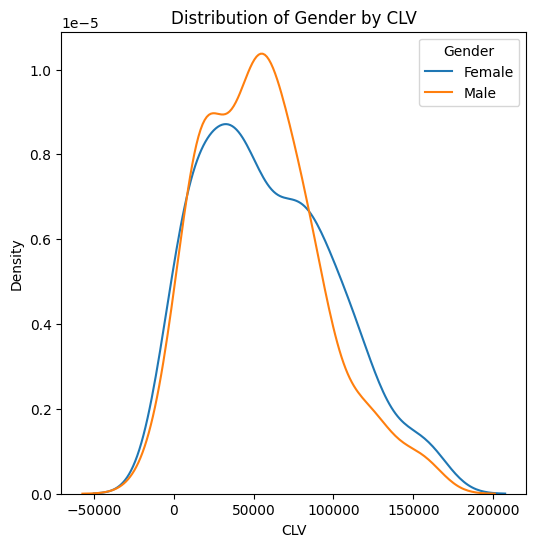

In [47]:
#Function for calling KDE Plot type distribution models of categorical distributions.
    #Feature = String value of categoric data column.
    #Categories = Unique labels of each categoric column. Used for sorting legend labels.
def ta_distributions(feature, categories):
    plt.figure(figsize=(6,6))

    for label in categories:
        subset = data[data[feature] == label]['CLV']
        sns.kdeplot(subset, label=label)
    
    plt.title(f'Distribution of {feature} by CLV')
    plt.ylabel('Density')
    plt.legend(title=feature)
    plt.show()

ta_distributions('Gender', data['Gender'].unique())

### Business Implications: ###
- Males: Broad base of dependable value.
    - Might be ideal for volume-driven strategies (e.g. retention, loyalty programs).
- Females: Represent strategic high-value individuals.
    - Ideal for personalized marketing, premium services, or VIP engagement.

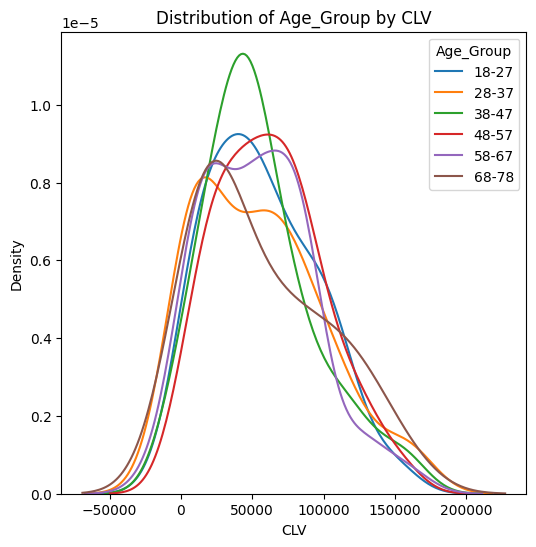

In [48]:
offset = 1
age_labels = ['18-27', '28-37', '38-47', '48-57', '58-67', '68-78']
age_bins = [17, 27, 37, 47, 57, 67, 78]
data['Age_Group'] = pd.cut(data['Age'], bins=age_bins, labels=[age_labels[x] for x in range(len(age_labels))])
data['Age_Group'] = data['Age_Group'].astype(str)

ta_distributions('Age_Group', age_labels)

### Business Implications: ###
- Older age groups progressively generate more value in exchange for lower customers.
    - Provide premium services to build brand loyalty of high value customers.
- Younger age groups are skewed towards lower value customers.
    - Build awareness with brand-building campaigns, reward them for repeat behaviour.
- Age group '38-47' shows the greatest density.
    - Strengthen core group via loyalty programs, more retention increases value as they get older.

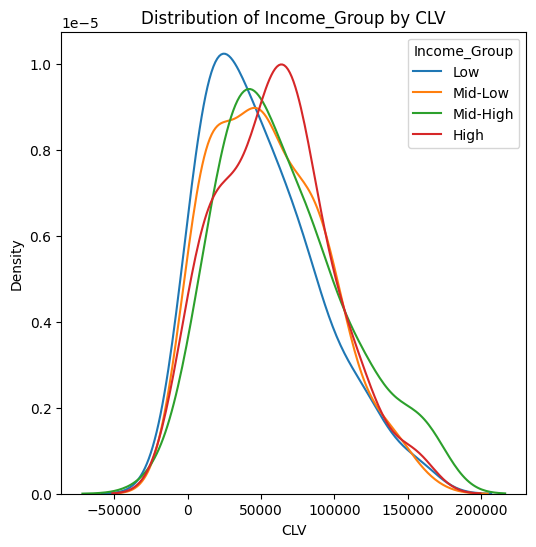

In [50]:
income_labels = ['Low', 'Mid-Low', 'Mid-High', 'High']
data['Income_Group'] = pd.qcut(data['Income'], q=4, labels=income_labels)

ta_distributions('Income_Group', income_labels)

<b> Where income is divide into quartiles based on minimum and maximum range. </b>

### Business Implications: ###
- Low & Mid-Low has the largest cumulative density but lowest value.
    - Encourage greater spending with bundled offers, or retention methods.
    - Subscription models for continuous value generation.
- Mid-High has the widest spread, can potentially be further segmented due to likelihood of high income customers being mixed in.
    - Loyalty programs for increased engagement.
    - Personalised marketing for brand value.
- High generates the most value on average, but low tail, suggesting untapped potential.
    - Personalized/premium offers for retention.
    - Consider value-added services to encourage more spending.

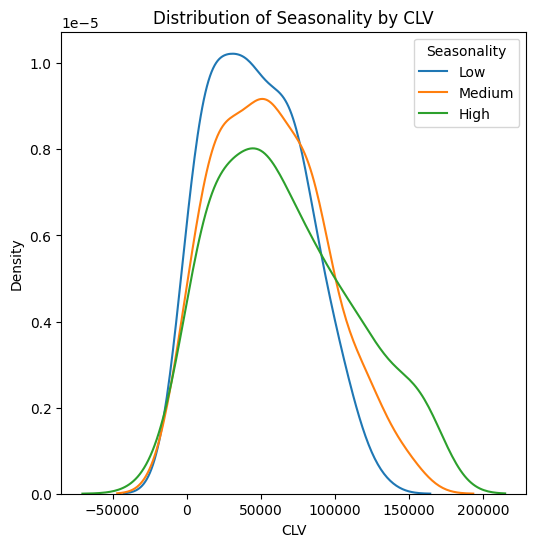

In [29]:
ta_distributions('Seasonality', data['Seasonality'].unique())

### Business Implications: ###
- Low & Mid seasonality customers contributes the most overall value and number of customers, suggesting less dependancy on on-peak seasons.
    - Less focus on seasonal marketing.
    - Consider non-seasonal incentives such as loyalty programs.
- High seasonality customers have high potential profit margins.
    - Experiment with offers during on-peak seasons such as limited-time bundles or value-added services during this period.

## 2 - Value ##

In [206]:
#Test for data analysis viability.
value_features = ['Sales', 'Marketing_Spend', 'Spending_Score', 'Purchase_Frequency', 'Seasonality_Factor']
kmo_model_value = calculate_kmo(data[value_features])

for x in range(len(kmo_model_value[0])):
    print(f'{value_features[x]} KMO Score: {kmo_model_value[0][x]:.4f}')

Sales KMO Score: 0.5338
Marketing_Spend KMO Score: 0.5052
Spending_Score KMO Score: 0.5058
Purchase_Frequency KMO Score: 0.4815
Seasonality_Factor KMO Score: 0.5033


Data prep

In [207]:
count_churn = data.loc[data['Customer_Churn'] == 1, 'Customer_Churn'].count()
#print(count_defaulted)
churn_false = data[data['Customer_Churn'] == 0]
churn_true = data[data['Customer_Churn'] == 1]

downsample_false = churn_false.sample(n=count_churn, random_state=0)

value_resampled = pd.concat([downsample_false, churn_true])
#print(risk_resampled.count())


value_resampled_x = value_resampled[value_features]
value_resampled_y = value_resampled['Customer_Churn']


X_train_value, X_test_value, y_train_value, y_test_value = train_test_split(value_resampled_x, value_resampled_y, test_size=0.25, random_state=0)

Random forest model

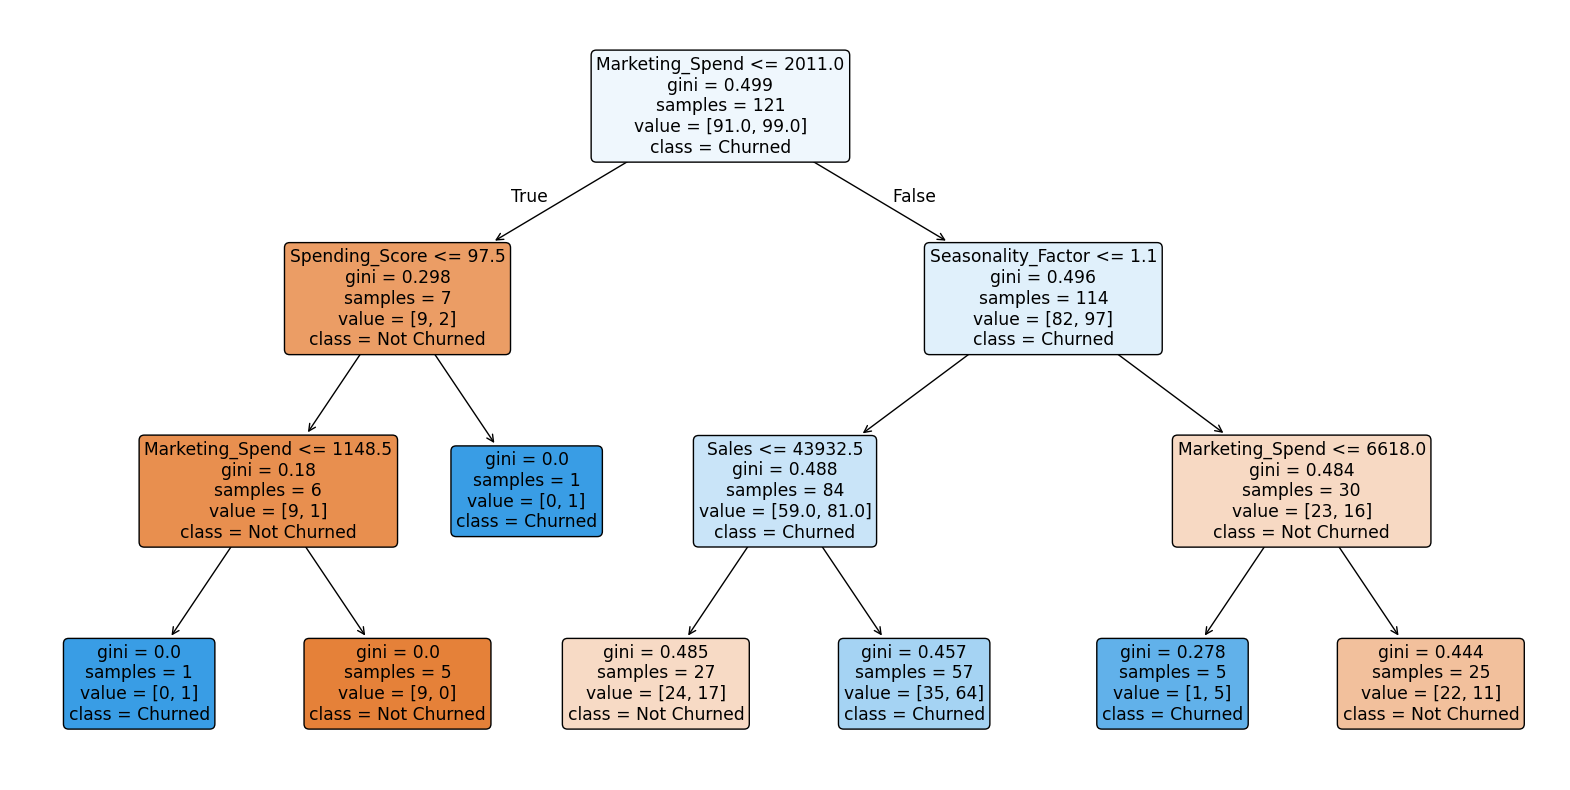

In [216]:
rf_model_value = RandomForestClassifier(random_state=0, oob_score=True, max_depth=3)
rf_model_value.fit(X_train_value, y_train_value)

y_predict_value = rf_model_value.predict(X_test_value)

estimator_value = rf_model_value.estimators_[0]

plt.figure(figsize=(20,10))

plot_tree(estimator_value, 
          feature_names=value_resampled_x.columns,
          class_names=['Not Churned', 'Churned'],
          filled=True, 
          rounded=True)

plt.show()

F1 Score (Non-Churned): 0.5000
F1 Score (Churned): 0.5000


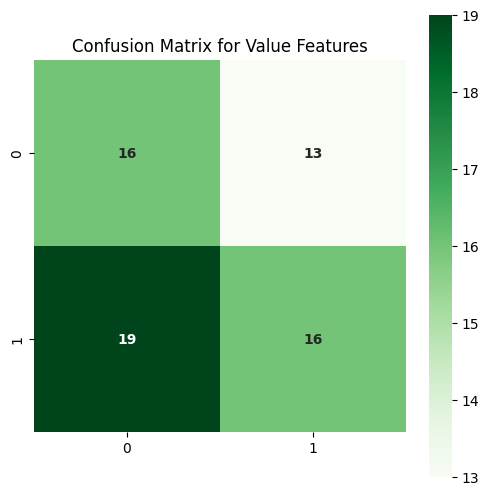

In [217]:
#Test the model
#print("\nClassification Report:\n", classification_report(y_test, y_predict))

risk_f1 = f1_score(y_test_value, y_predict_value, average=None)
print(f'F1 Score (Non-Churned): {risk_f1[0]:.4f}')
print(f'F1 Score (Churned): {risk_f1[1]:.4f}')

risk_confusion = confusion_matrix(y_test_value, y_predict_value)

plt.figure(figsize=(6,6))
sns.heatmap(risk_confusion, cmap='Greens', square=True, annot=True, annot_kws={'fontweight' : 'bold'}, fmt='g')
plt.title('Confusion Matrix for Value Features')
plt.show()

In [218]:
importances = rf_model_value.feature_importances_

print('Feature Weightings:')
for x in range(len(value_features)):
    print(f'{value_features[x]} Importance: {importances[x]:.4f}')

Feature Weightings:
Sales Importance: 0.2934
Marketing_Spend Importance: 0.2523
Spending_Score Importance: 0.2322
Purchase_Frequency Importance: 0.1968
Seasonality_Factor Importance: 0.0252


## 3 - Risk ##

#### Identifying risk components ####

In [195]:
#Test for data analysis viability.
kmo_test_risk = ['Loan_Amount', 'Income', 'Credit_Score', 'Previous_Defaults', 'Defaulted', 'Loss']
kmo_model_risk = calculate_kmo(data[kmo_test_risk])

for x in range(len(kmo_model_risk[0])):
    print(f'{kmo_test_risk[x]} KMO Score: {kmo_model_risk[0][x]:.4f}')

Loan_Amount KMO Score: 0.4671
Income KMO Score: 0.4689
Credit_Score KMO Score: 0.4804
Previous_Defaults KMO Score: 0.4962
Defaulted KMO Score: 0.4852
Loss KMO Score: 0.4810


Data prep

In [196]:
risk_features = ['Loan_Amount', 'Income', 'Credit_Score', 'Previous_Defaults']

count_defaulted = data.loc[data['Defaulted'] == 1, 'Defaulted'].count()
#print(count_defaulted)
defaulted_false = data[data['Defaulted'] == 0]
defaulted_true = data[data['Defaulted'] == 1]

downsample_false = defaulted_false.sample(n=count_defaulted, random_state=0)

risk_resampled = pd.concat([downsample_false, defaulted_true])
#print(risk_resampled.count())


risk_resampled_x = risk_resampled[risk_features]
risk_resampled_y = risk_resampled['Defaulted']


X_train_risk, X_test_risk, y_train_risk, y_test_risk = train_test_split(risk_resampled_x, risk_resampled_y, test_size=0.25, random_state=0)

Random Forest Modeling

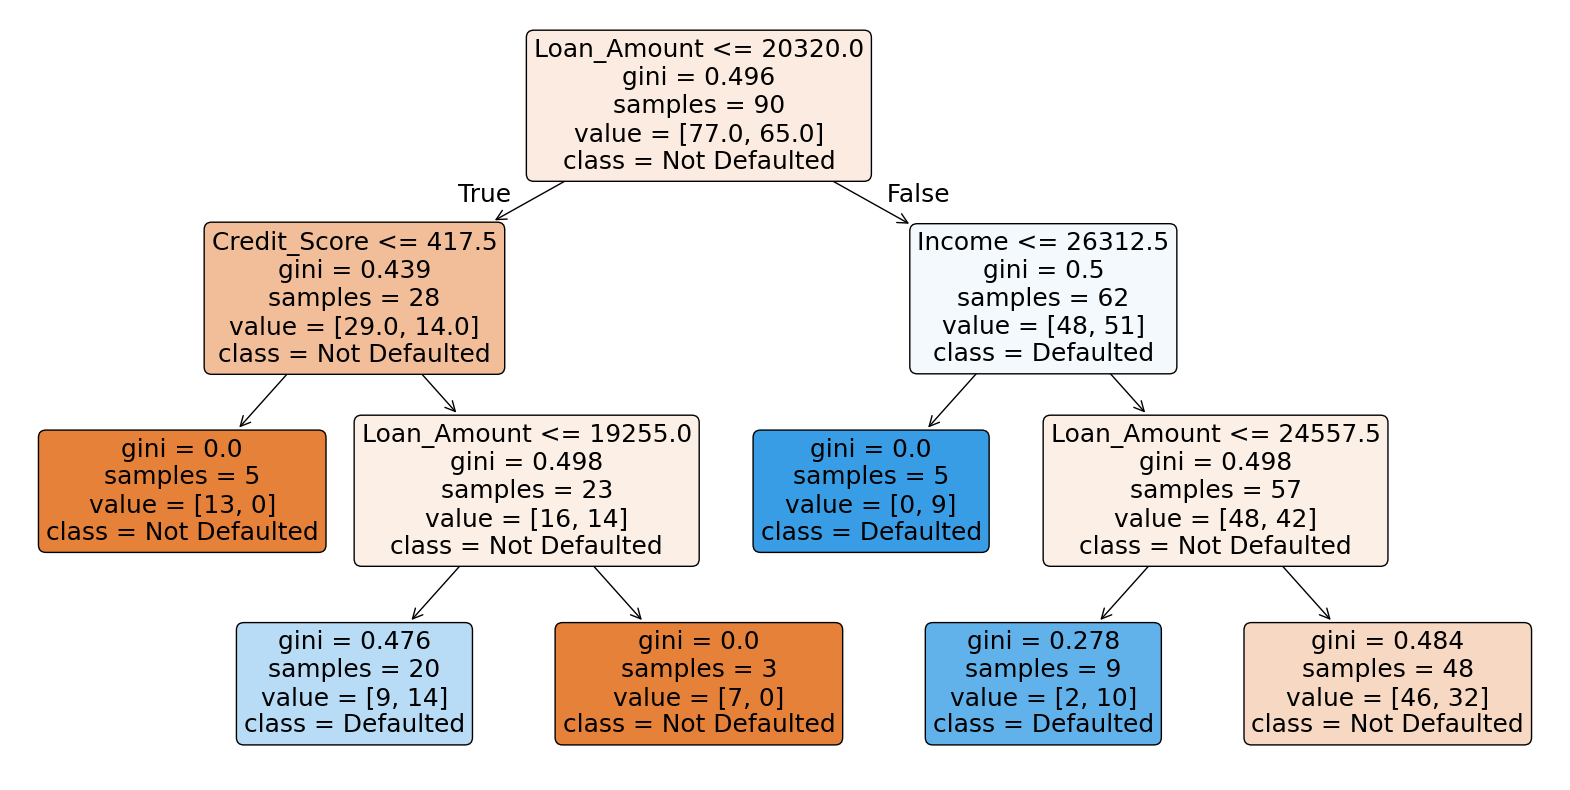

In [197]:
rf_model_risk = RandomForestClassifier(random_state=0, oob_score=True, max_depth=3)
rf_model_risk.fit(X_train_risk, y_train_risk)

y_predict = rf_model_risk.predict(X_test_risk)

estimator_risk = rf_model_risk.estimators_[0]

plt.figure(figsize=(20,10))

plot_tree(estimator_risk, 
          feature_names=risk_resampled_x.columns,
          class_names=['Not Defaulted', 'Defaulted'],
          filled=True, 
          rounded=True)

plt.show()

Accuracy Score: 0.5417

F1 Score (Non-Defaulted): 0.5600
F1 Score (Defaulted): 0.5217


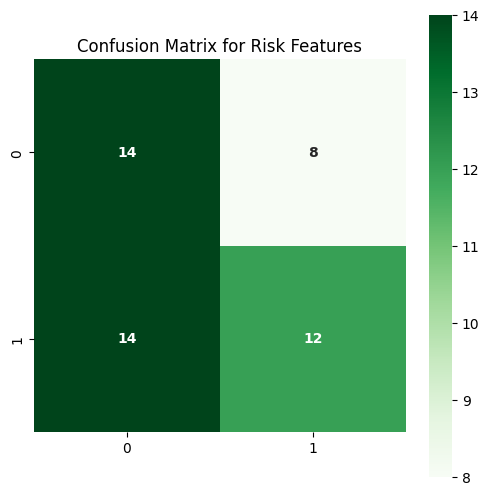

In [220]:
#Test the model
#print("\nClassification Report:\n", classification_report(y_test, y_predict))

risk_accuracy = accuracy_score(y_test_risk, y_predict)
print(f"Accuracy Score: {risk_accuracy:.4f}")

risk_f1 = f1_score(y_test_risk, y_predict, average=None)
print(f'\nF1 Score (Non-Defaulted): {risk_f1[0]:.4f}')
print(f'F1 Score (Defaulted): {risk_f1[1]:.4f}')

risk_confusion = confusion_matrix(y_test_risk, y_predict)

plt.figure(figsize=(6,6))
sns.heatmap(risk_confusion, cmap='Greens', square=True, annot=True, annot_kws={'fontweight' : 'bold'}, fmt='g')
plt.title('Confusion Matrix for Risk Features')
plt.show()

#### Methodology: ####
The following were originally considered as risk features for determining defaults based on business logic:
- Income
- Loan Amount
- Credit Score
- Previous Defaults

Methods Tried:
- KMeans for segmentation with normalised PCAs.
    - A lot of overlap between clusters, no meaningful insights could be drawn.
- Factor Analysis.
    - KMO Score were all below 0.6. Data Analysis not applicable.
- Logistic Regression using Defaulted at y-axis.
    - No field/combination showed any form of logistic regression.
- Random Forest.
    - Generated a tree that can't properly classify true negatives (defaulted customers) when depth limit is none - underfitted.
    - Likely due to Defaulted being imbalanced. 
    - The only analytical method that has generated insights.
    - Depth condensed to 3 for readability. It wasn't classifying well when the depth was deeper so it won't make any meaningful difference.

Feature weightings of risk

In [199]:
importances = rf_model_risk.feature_importances_

print('Feature Weightings:')
for x in range(len(risk_features)):
    print(f'{risk_features[x]} Importance: {importances[x]:.4f}')

Feature Weightings:
Loan_Amount Importance: 0.3430
Income Importance: 0.3067
Credit_Score Importance: 0.3170
Previous_Defaults Importance: 0.0333


Implications:
- Loan Amount, Income Importance, Credit Score - Around equal importance.
- Previous Defaults is negligible 
    - Worth noting that it is the only real-world tangible evidence of customer risk. 
    - Consider adding weights to normalise.

Formula for Risk Score

In [ ]:
from sklearn.preprocessing import MinMaxScaler

#Maximum score of a FICO Credit Score model.
fico_max = 850

#Normalise data with large ranges.
minMax_scaler = MinMaxScaler()
scaled = minMax_scaler.fit_transform(data[['Loan_Amount', 'Income']])
data[['Loan_Amount_Scaled', 'Income_Scaled']] = scaled

data['Risk_Score'] = (
    ((fico_max - data['Credit_Score']) / 100) +
    2 * data['Previous_Defaults'] +
    data['Loan_Amount_Scaled'] +
    data['Income_Scaled']
)

#print(data['Risk_Score'].describe())

count    500.000000
mean       5.718811
std        2.270004
min        0.299965
25%        4.027422
50%        5.645075
75%        7.505427
max       10.563076
Name: Risk_Score, dtype: float64


Identifying Linear Relationships

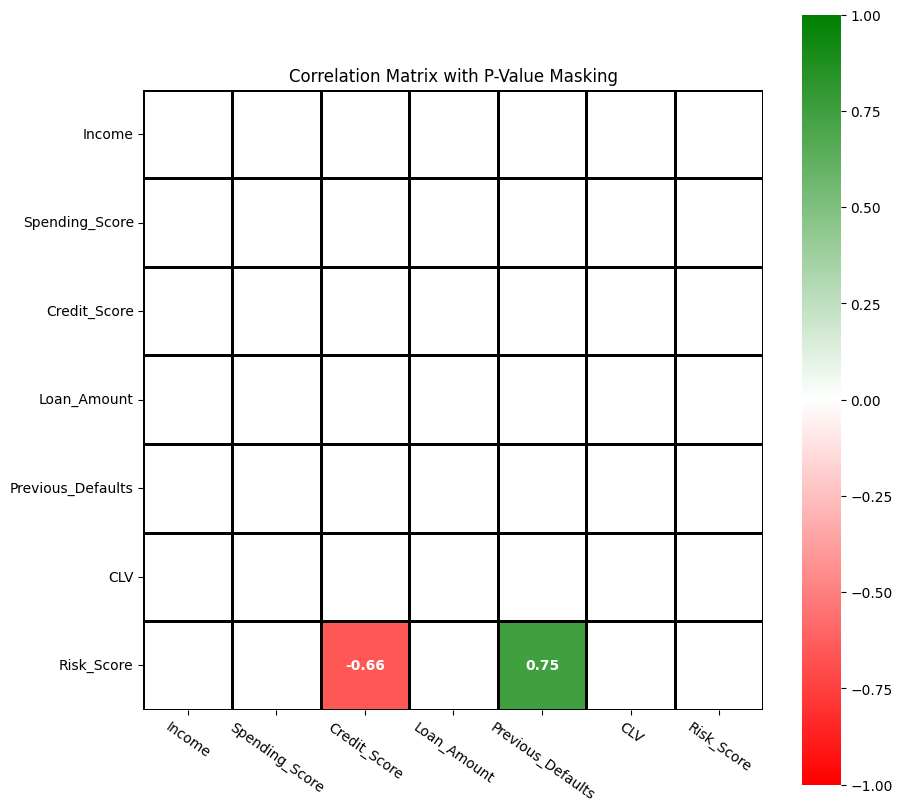

In [180]:
risk_corrTest = ['Income', 'Spending_Score', 'Credit_Score', 'Loan_Amount', 'Previous_Defaults', 'CLV', 'Risk_Score']

corr_data = data[risk_corrTest].corr()
#print(corr_data)

gradient = LinearSegmentedColormap.from_list('rg',["r", "w", "g"], N=256) 
p_values_corr = round(corr_data.corr(method=lambda x, y: pearsonr(x, y)[1]), 4)
#print(p_values_corr)

#Where p-values below (default) 0.05 are statistical significant.
stat_sig = 0.05

#Masks
mask = np.triu(corr_data)
p_mask = np.invert(np.tril(p_values_corr < stat_sig))

x, fig = plt.subplots(figsize=(10,10))

sns.heatmap(corr_data, mask=p_mask, cmap=gradient, vmin=-1, vmax=1, linewidths=2, linecolor='black', annot=True, annot_kws={'fontweight' : 'bold'}, square=True)
plt.title('Correlation Matrix with P-Value Masking')
plt.xticks(rotation=-35)
plt.show()

- Low credit score = Higher risk score, which is logically true.
- Higher past defaults = Higher risk score, which is logically true.

Quartile Bin Classification

In [62]:
risk_q1 = data['Risk_Score'].quantile(0.25)
risk_q3 = data['Risk_Score'].quantile(0.75)

def bin_quartiles(x):
    if x <= risk_q1:
        return 'Low'
    elif x >= risk_q3:
        return 'High'
    else:
        return 'Medium'
    
data['Risk_Value'] = data['Risk_Score'].apply(bin_quartiles)
    
#print(data[['Risk_Score', 'Risk_Value']])

## 4 - Customer Segmentation ##

#### KMeans Clustering ####

In [63]:
assess_features = ['CLV', 'Risk_Score']

#Ranges of both features are too far apart. Not suitable for KMeans which uses Euclidean distance.
sd_scaler = StandardScaler()

k_data = data[assess_features]
k_data_scaled = sd_scaler.fit_transform(k_data)

Identify a Suitable Value for k (clusters) w/ Elbow Method & Silhouette Scores

Where k=2, Silhouette Score: 0.3255
Where k=3, Silhouette Score: 0.3736
Where k=4, Silhouette Score: 0.3600
Where k=5, Silhouette Score: 0.3217
Where k=6, Silhouette Score: 0.3218
Where k=7, Silhouette Score: 0.3524
Where k=8, Silhouette Score: 0.3315
Where k=9, Silhouette Score: 0.3527

Optimal number of clusters k: 3


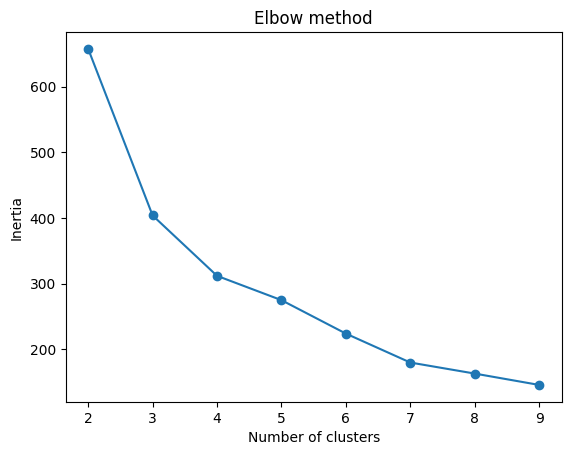

In [64]:
inertia = []
best_k = 1
best_inertia = 0

for k in range(2,10):
        kmeans = KMeans(n_clusters=k)
        labels = kmeans.fit_predict(k_data_scaled)
        s_score = silhouette_score(k_data_scaled, labels)

        if s_score > best_inertia:
                best_inertia = s_score
                best_k = k

        print(f"Where k={k}, Silhouette Score: {s_score:.4f}")
        inertia.append(kmeans.inertia_)

print(f'\nOptimal number of clusters k: {best_k}')

plt.plot(range(2,10), inertia, marker='o')
plt.title('Elbow method')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.show()   

KMeans w/ Centroids

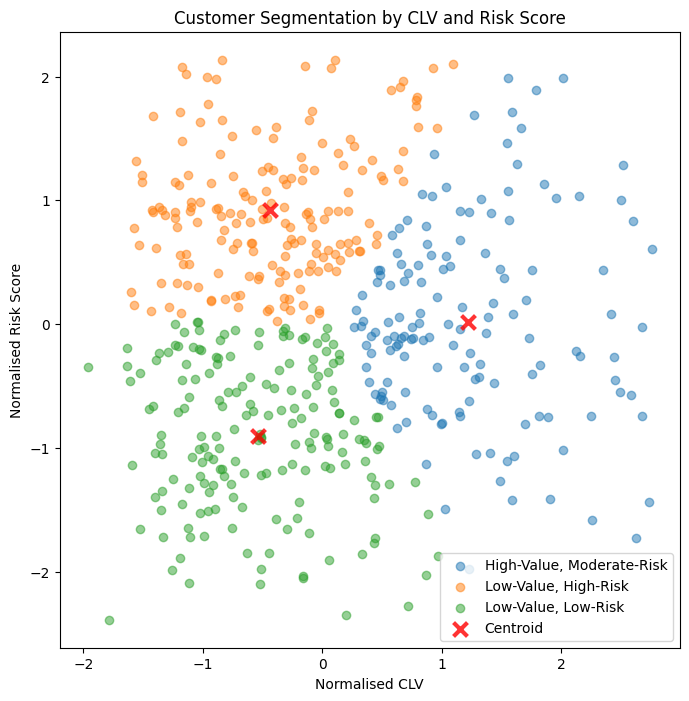

In [88]:
cluster_label = ['High-Value, Moderate-Risk', 'Low-Value, High-Risk', 'Low-Value, Low-Risk']

kmeans = KMeans(n_clusters=best_k, random_state=0)
data['Customer_Segment'] = kmeans.fit_predict(k_data_scaled)

centroids = kmeans.cluster_centers_

plt.figure(figsize=(8,8))

for cluster in range(best_k):
    cluster_points = k_data_scaled[kmeans.labels_ == cluster]
    plt.scatter(cluster_points[:, 0], cluster_points[:, 1], alpha=0.5, label=cluster_label[cluster])

plt.scatter(centroids[:, 0], centroids[:, 1], c='red', marker='x', label='Centroid', alpha=0.8, linewidths=3, s=100)
plt.xlabel('Normalised CLV')
plt.ylabel('Normalised Risk Score')
plt.title('Customer Segmentation by CLV and Risk Score')
plt.legend()
plt.show()

### Business Implications: ###
- Clear seperation by value (left and right side).
- Low-value customers can be further split by risk.

Potential Strategies:
- Low-CLV, Low-Risk - Most stable customer segment.
    - Retention methods such as loyalty programs, or re-engagement campaigns.
    - Consider upselling with bundled offers, or value-added services such as first-day delivery.
    - Subscription models for sustained value generation.
    - Use cost effective methods such as social media/email marketing.
- Low-CLV, High-Risk - The risk prone segment.
    - Real-time risk flagging.
    - Consider limiting credit exposure for individual customers or regions, or terminating credit transactions for repeat offenders.
    - Spending caps and approval thresholds for risk mitigation.
    - Automated payment reminders.
    - Offer restructuring or partial forgiveness for value recovery of defaulted customers.
- High-Value, Moderate-Risk - The most profitable segment, consisting of the highest spenders.
    - VIP benefits for brand loyalty.
    - Increase credit-cap based on successful repayments.
    - Add tiers to VIPs based on payment behaviour - Those who have low risk deserve better treatment. Builds an incentive around goodwill and trust.
    - Personalized service for risk flagging - e.g. letters of credit.


## 5 - Identifying a Risk Threshold ##

In [143]:
count_defaulted = data[data['Defaulted'] == 1].groupby('Customer_Segment').size()
count_notDefaulted = data[data['Defaulted'] == 0].groupby('Customer_Segment').size()

#print(count_defaulted)
#print(count_notDefaulted)

riskiest_segment = 0

for x in range(best_k):
    default_rate = round((count_defaulted[x]/count_notDefaulted[x]) * 100, 4)
    #print(default_rate)

    if default_rate > riskiest_segment:
        riskiest_segment = x

print(f'Segment with highest default rate: {riskiest_segment}')

riskKmeans_threshold = round(data[data['Customer_Segment'] == riskiest_segment]['Risk_Score'].mean(), 4)
print(f'\nAverage Risk of Default in segment {riskiest_segment}: {riskKmeans_threshold}')

Segment with highest default rate: 2

Average Risk of Default in segment 2: 3.662


Test the threshold from average risk score of the highest risk cluster.


F1 Score (Non-Defaulted): 0.3176
F1 Score (Defaulted): 0.2898


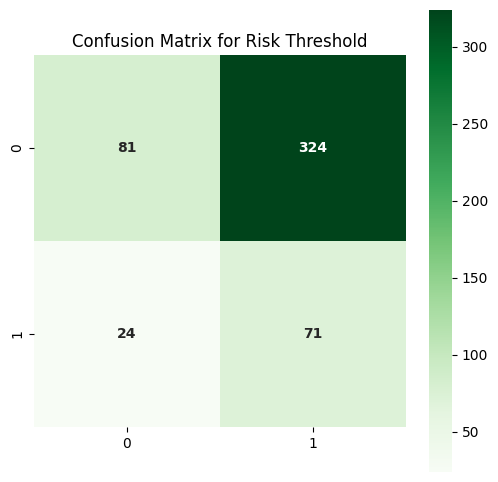


Classification Report:
               precision    recall  f1-score   support

           0       0.77      0.20      0.32       405
           1       0.18      0.75      0.29        95

    accuracy                           0.30       500
   macro avg       0.48      0.47      0.30       500
weighted avg       0.66      0.30      0.31       500



In [223]:
data['Predicted_High_Risk'] = (data['Risk_Score'] >= riskKmeans_threshold).astype(int)

threshold_true = data['Defaulted']
threshold_pred = data['Predicted_High_Risk']

threshold_f1 = f1_score(threshold_true, threshold_pred, average=None)
print(f'\nF1 Score (Non-Defaulted): {threshold_f1[0]:.4f}')
print(f'F1 Score (Defaulted): {threshold_f1[1]:.4f}')

avgThreshold_confusion = confusion_matrix(threshold_true, threshold_pred)

# Confusion Matrix
#print("\nConfusion Matrix:\n", confusion_matrix(threshold_true, threshold_pred))

plt.figure(figsize=(6,6))
sns.heatmap(avgThreshold_confusion, cmap='Greens', square=True, annot=True, annot_kws={'fontweight' : 'bold'}, fmt='g')
plt.title('Confusion Matrix for Risk Threshold')
plt.show()

print("\nClassification Report:\n", classification_report(threshold_true, threshold_pred))

Basic decision tree model

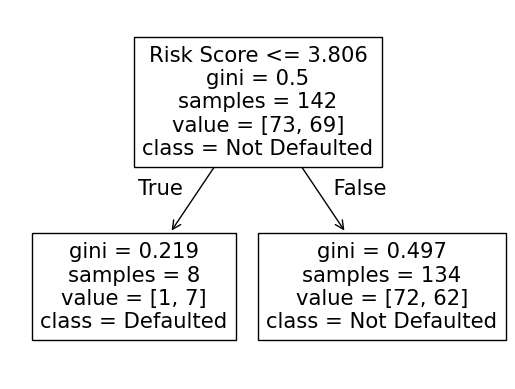

In [139]:
rsX_train, rsX_test, rsY_train, rsY_test = train_test_split(risk_resampled[['Risk_Score']], risk_resampled['Defaulted'], test_size=0.25, random_state=0)

threshold_model = DecisionTreeClassifier(random_state=0, max_depth=1)
threshold_model.fit(rsX_train, rsY_train)
threshold_modelPred = threshold_model.predict(rsX_test)

plot_tree(threshold_model, class_names=['Not Defaulted', 'Defaulted'], feature_names=['Risk Score'])
plt.show()

Test the tree model.

F1 Score (Non-Defaulted): 0.6471
F1 Score (Defaulted): 0.1429


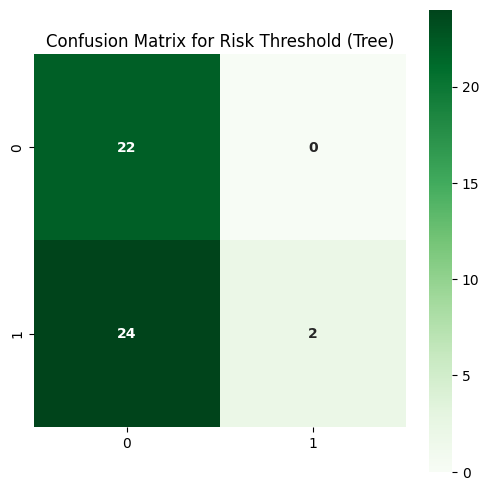

In [224]:
riskTree_threshold = threshold_model.tree_.threshold[0]
#print(riskTree_threshold)

threshold_confusion = confusion_matrix(rsY_test, threshold_modelPred)

threshold_f1 = f1_score(rsY_test, threshold_modelPred, average=None)
print(f'F1 Score (Non-Defaulted): {threshold_f1[0]:.4f}')
print(f'F1 Score (Defaulted): {threshold_f1[1]:.4f}')

plt.figure(figsize=(6,6))
sns.heatmap(threshold_confusion, cmap='Greens', square=True, annot=True, annot_kws={'fontweight' : 'bold'}, fmt='g')
plt.title('Confusion Matrix for Risk Threshold (Tree)')
plt.show()

Identify a threshold using the past two models.
- Business would want to prioritise catching defaulter even at the expense of misclassifying non-defaulters.
    - KMeans model is better at catching defaulters, but extremely low precision - It's flagging a lot of non-defaulters.
    - Tree model is too conservative, and missed most defaulters.
- Ideally a balance of the two is ideal for cost-efficiency.
- Consider weightings.
    - Priority on KMeans, but consider tree model.

In [150]:
greater_weight = 0.75
lesser_weight = 0.25

risk_threshold = round((greater_weight * riskKmeans_threshold) + (lesser_weight * riskTree_threshold), 4)
print(f'Risk Threshold: {risk_threshold}')

Risk Threshold: 3.6981


### Business Considerations: ###
- Customers with a risk score above threshold value (<b>3.6981</b>) should be flagged.
- Different treatments offlagged customers based on customer segment:
    - Low-CLV, Low-Risk 
        - Soft/passive interventions such as notifications. 
        - Let low-risk flags accumulate before acting - treat first offense as a warning.
    - Low-CLV, High-Risk 
        - Auto-limit credit limit, and manual approval of large orders.
        - Automated reminders and escalations if needed.
        - Partial forgiveness with exit clause.
    - High-CLV, Moderate-Risk
        - Consider internal flagging, but no action unless repeated offense.
        - Offer alternative financing options or grace periods.
        - Raise threshold as needed.